# LSTM Step-by-Step: Processing "I love NLP"

## Setup
- Sentence: **"I love NLP"**
- Hidden units: **4**
- Embedding dimension: **3**
- **Same as RNN example for comparison!**

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, FancyBboxPatch, FancyArrowPatch

# Set random seed for reproducibility
np.random.seed(42)

# Configuration (SAME as RNN)
vocab = {"I": 0, "love": 1, "NLP": 2}
embedding_dim = 3
hidden_units = 4

print("Vocabulary:", vocab)
print(f"Embedding dimension: {embedding_dim}")
print(f"Hidden units: {hidden_units}")
print(f"\nLSTM has TWO states:")
print(f"  - Hidden state (h_t): {hidden_units}-dimensional vector")
print(f"  - Cell state (C_t): {hidden_units}-dimensional vector")

Vocabulary: {'I': 0, 'love': 1, 'NLP': 2}
Embedding dimension: 3
Hidden units: 4

LSTM has TWO states:
  - Hidden state (h_t): 4-dimensional vector
  - Cell state (C_t): 4-dimensional vector


## LSTM Architecture Overview

### Key Difference from RNN:
```
RNN:  Only hidden state (h_t)
LSTM: Hidden state (h_t) + Cell state (C_t)
```

### LSTM Gates:
1. **Forget Gate (f_t)**: Decides what to forget from cell state
2. **Input Gate (i_t)**: Decides what new information to add
3. **Output Gate (o_t)**: Decides what to output

### LSTM Equations:
```python
f_t = sigmoid(W_f @ [h_{t-1}, x_t] + b_f)  # Forget gate
i_t = sigmoid(W_i @ [h_{t-1}, x_t] + b_i)  # Input gate
C_tilde = tanh(W_C @ [h_{t-1}, x_t] + b_C) # Candidate cell state
C_t = f_t ⊙ C_{t-1} + i_t ⊙ C_tilde        # New cell state
o_t = sigmoid(W_o @ [h_{t-1}, x_t] + b_o)  # Output gate
h_t = o_t ⊙ tanh(C_t)                       # New hidden state
```
where ⊙ denotes element-wise multiplication

## Step 1: Create Embedding Matrix (SAME as RNN)

In [14]:
# Embedding matrix (SAME as RNN example)
embedding_matrix = np.array([
    [0.5, 0.2, 0.1],   # "I"
    [0.8, 0.6, 0.3],   # "love"
    [0.1, 0.9, 0.7]    # "NLP"
])

print("Embedding Matrix:")
print(embedding_matrix)

# Get embeddings for our sentence
sentence = ["I", "love", "NLP"]
sentence_ids = [vocab[word] for word in sentence]
embeddings = embedding_matrix[sentence_ids]

print("\nWord Embeddings:")
for i, word in enumerate(sentence):
    print(f"{word:6s}: {embeddings[i]}")

Embedding Matrix:
[[0.5 0.2 0.1]
 [0.8 0.6 0.3]
 [0.1 0.9 0.7]]

Word Embeddings:
I     : [0.5 0.2 0.1]
love  : [0.8 0.6 0.3]
NLP   : [0.1 0.9 0.7]


## Step 2: Initialize LSTM Weights

LSTM has 4 sets of weights (one for each gate + candidate):
- Forget gate: W_f, b_f
- Input gate: W_i, b_i
- Candidate: W_C, b_C
- Output gate: W_o, b_o

In [15]:
# Simplified weights for demonstration
# In reality, W concatenates [h, x] so shape is (hidden_units, embedding_dim + hidden_units)
# For simplicity, we'll separate W_h and W_x

# Forget gate weights
W_f_x = np.array([[0.1, 0.2, 0.1], [0.2, 0.1, 0.2], [0.1, 0.2, 0.1], [0.2, 0.1, 0.2]])
W_f_h = np.array([[0.2, 0.1, 0.1, 0.2], [0.1, 0.2, 0.2, 0.1], [0.2, 0.1, 0.1, 0.2], [0.1, 0.2, 0.2, 0.1]])
b_f = np.array([0.5, 0.5, 0.5, 0.5])  # Bias towards remembering

# Input gate weights
W_i_x = np.array([[0.2, 0.1, 0.2], [0.1, 0.2, 0.1], [0.2, 0.1, 0.2], [0.1, 0.2, 0.1]])
W_i_h = np.array([[0.1, 0.2, 0.2, 0.1], [0.2, 0.1, 0.1, 0.2], [0.1, 0.2, 0.2, 0.1], [0.2, 0.1, 0.1, 0.2]])
b_i = np.array([0.1, 0.1, 0.1, 0.1])

# Candidate weights
W_C_x = np.array([[0.3, 0.2, 0.1], [0.2, 0.3, 0.2], [0.1, 0.2, 0.3], [0.2, 0.1, 0.2]])
W_C_h = np.array([[0.2, 0.1, 0.3, 0.2], [0.1, 0.2, 0.2, 0.1], [0.3, 0.2, 0.1, 0.3], [0.2, 0.3, 0.2, 0.1]])
b_C = np.array([0.1, 0.1, 0.1, 0.1])

# Output gate weights
W_o_x = np.array([[0.2, 0.3, 0.2], [0.3, 0.2, 0.3], [0.2, 0.3, 0.2], [0.3, 0.2, 0.3]])
W_o_h = np.array([[0.3, 0.2, 0.2, 0.3], [0.2, 0.3, 0.3, 0.2], [0.3, 0.2, 0.2, 0.3], [0.2, 0.3, 0.3, 0.2]])
b_o = np.array([0.1, 0.1, 0.1, 0.1])

print("LSTM Weight Shapes:")
print(f"W_f_x: {W_f_x.shape} - maps input (3) to hidden (4)")
print(f"W_f_h: {W_f_h.shape} - maps hidden (4) to hidden (4)")
print(f"(Same shapes for input, candidate, and output gates)\n")

print("Total parameters for LSTM:")
total_params = 4 * (W_f_x.size + W_f_h.size + b_f.size)
print(f"4 gates × (W_x + W_h + b) = 4 × ({W_f_x.size} + {W_f_h.size} + {b_f.size}) = {total_params}")
print(f"\nCompare to RNN: 2 matrices (W_xh + W_hh) + 1 bias = {(3*4) + (4*4) + 4} parameters")
print(f"LSTM has ~4× more parameters than simple RNN!")

LSTM Weight Shapes:
W_f_x: (4, 3) - maps input (3) to hidden (4)
W_f_h: (4, 4) - maps hidden (4) to hidden (4)
(Same shapes for input, candidate, and output gates)

Total parameters for LSTM:
4 gates × (W_x + W_h + b) = 4 × (12 + 16 + 4) = 128

Compare to RNN: 2 matrices (W_xh + W_hh) + 1 bias = 32 parameters
LSTM has ~4× more parameters than simple RNN!


## Helper Functions

In [22]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def lstm_step(x_t, h_prev, C_prev):
    """Single LSTM forward step"""
    
    # Forget gate - NO .T!
    f_t = sigmoid(W_f_x @ x_t + W_f_h @ h_prev + b_f)
    
    # Input gate - NO .T!
    i_t = sigmoid(W_i_x @ x_t + W_i_h @ h_prev + b_i)
    
    # Candidate cell state - NO .T!
    C_tilde = np.tanh(W_C_x @ x_t + W_C_h @ h_prev + b_C)
    
    # New cell state
    C_t = f_t * C_prev + i_t * C_tilde
    
    # Output gate - NO .T!
    o_t = sigmoid(W_o_x @ x_t + W_o_h @ h_prev + b_o)
    
    # New hidden state
    h_t = o_t * np.tanh(C_t)
    
    return h_t, C_t, f_t, i_t, o_t, C_tilde

print("LSTM step function updated!")

print("LSTM forward step function defined!")

LSTM step function updated!
LSTM forward step function defined!


## Step 3: Initialize States

In [17]:
# Initialize hidden state and cell state (both zeros)
h_0 = np.zeros(hidden_units)
C_0 = np.zeros(hidden_units)

print("Initial states:")
print(f"Hidden state h_0: {h_0}")
print(f"Cell state C_0:   {C_0}")
print(f"\nBoth are {hidden_units}-dimensional vectors")
print("="*70)

Initial states:
Hidden state h_0: [0. 0. 0. 0.]
Cell state C_0:   [0. 0. 0. 0.]

Both are 4-dimensional vectors


## Time Step 1: Process "I"

In [23]:
x_1 = embeddings[0]  # "I"
h_prev, C_prev = h_0, C_0

print("TIME STEP 1: Processing 'I'")
print("="*70)
print(f"Input x_1 ('I'):        {x_1}")
print(f"Previous hidden h_0:    {h_prev}")
print(f"Previous cell C_0:      {C_prev}")
print()

# Just call lstm_step directly - no reshaping needed!
h_1, C_1, f_1, i_1, o_1, C_tilde_1 = lstm_step(x_1, h_prev, C_prev)

print("Gate Activations:")
print(f"Forget gate f_1:        {f_1}")
print(f"  → Controls what to forget from C_0 (close to 1 = remember, 0 = forget)")
print()
print(f"Input gate i_1:         {i_1}")
print(f"  → Controls what new info to add (close to 1 = add, 0 = ignore)")
print()
print(f"Candidate C̃_1:          {C_tilde_1}")
print(f"  → New information to potentially add")
print()
print(f"Output gate o_1:        {o_1}")
print(f"  → Controls what to output (close to 1 = output, 0 = hide)")
print()
print("="*70)
print("State Updates:")
print(f"New cell state C_1:     {C_1}")
print(f"  = f_1 ⊙ C_0 + i_1 ⊙ C̃_1")
print(f"  = (forget old) + (add new)")
print()
print(f"New hidden state h_1:   {h_1}")
print(f"  = o_1 ⊙ tanh(C_1)")
print("="*70)
print()

TIME STEP 1: Processing 'I'
Input x_1 ('I'):        [0.5 0.2 0.1]
Previous hidden h_0:    [0. 0. 0. 0.]
Previous cell C_0:      [0. 0. 0. 0.]

Gate Activations:
Forget gate f_1:        [0.64565631 0.65475346 0.64565631 0.65475346]
  → Controls what to forget from C_0 (close to 1 = remember, 0 = forget)

Input gate i_1:         [0.55971365 0.549834   0.55971365 0.549834  ]
  → Controls what new info to add (close to 1 = add, 0 = ignore)

Candidate C̃_1:          [0.29131261 0.27290508 0.21651806 0.23549575]
  → New information to potentially add

Output gate o_1:        [0.56954622 0.57932425 0.56954622 0.57932425]
  → Controls what to output (close to 1 = output, 0 = hide)

State Updates:
New cell state C_1:     [0.16305165 0.15005249 0.12118811 0.12948357]
  = f_1 ⊙ C_0 + i_1 ⊙ C̃_1
  = (forget old) + (add new)

New hidden state h_1:   [0.09205114 0.08628245 0.06868631 0.07459654]
  = o_1 ⊙ tanh(C_1)



## Time Step 2: Process "love"

In [24]:
x_2 = embeddings[1]  # "love"
h_prev, C_prev = h_1, C_1

print("TIME STEP 2: Processing 'love'")
print("="*70)
print(f"Input x_2 ('love'):     {x_2}")
print(f"Previous hidden h_1:    {h_prev}")
print(f"Previous cell C_1:      {C_prev}")
print(f"  ↑ Contains memory of 'I'")
print()

h_2, C_2, f_2, i_2, o_2, C_tilde_2 = lstm_step(x_2, h_prev, C_prev)

print("Gate Activations:")
print(f"Forget gate f_2:        {f_2}")
print(f"  → Decides what to keep from C_1 (memory of 'I')")
print()
print(f"Input gate i_2:         {i_2}")
print(f"  → Decides how much 'love' info to add")
print()
print(f"Candidate C̃_2:          {C_tilde_2}")
print()
print(f"Output gate o_2:        {o_2}")
print()
print("="*70)
print("State Updates:")
print(f"New cell state C_2:     {C_2}")
print(f"  = f_2 ⊙ C_1 + i_2 ⊙ C̃_2")
print(f"  = (kept some of 'I') + (added 'love' info)")
print()
print(f"New hidden state h_2:   {h_2}")
print(f"  = o_2 ⊙ tanh(C_2)")
print(f"  Now encodes 'I love'")
print("="*70)
print()

TIME STEP 2: Processing 'love'
Input x_2 ('love'):     [0.8 0.6 0.3]
Previous hidden h_1:    [0.09205114 0.08628245 0.06868631 0.07459654]
Previous cell C_1:      [0.16305165 0.15005249 0.12118811 0.12948357]
  ↑ Contains memory of 'I'

Gate Activations:
Forget gate f_2:        [0.68542712 0.69585961 0.68542712 0.69585961]
  → Decides what to keep from C_1 (memory of 'I')

Input gate i_2:         [0.60531441 0.59359002 0.60531441 0.59359002]
  → Decides how much 'love' info to add

Candidate C̃_2:          [0.50243916 0.49876326 0.4334357  0.41818629]

Output gate o_2:        [0.64129473 0.65244868 0.64129473 0.65244868]

State Updates:
New cell state C_2:     [0.41589368 0.40047636 0.34543049 0.33833359]
  = f_2 ⊙ C_1 + i_2 ⊙ C̃_2
  = (kept some of 'I') + (added 'love' info)

New hidden state h_2:   [0.25232732 0.24816309 0.21311305 0.21269102]
  = o_2 ⊙ tanh(C_2)
  Now encodes 'I love'



## Time Step 3: Process "NLP"

In [25]:
x_3 = embeddings[2]  # "NLP"
h_prev, C_prev = h_2, C_2

print("TIME STEP 3: Processing 'NLP'")
print("="*70)
print(f"Input x_3 ('NLP'):      {x_3}")
print(f"Previous hidden h_2:    {h_prev}")
print(f"Previous cell C_2:      {C_prev}")
print(f"  ↑ Contains memory of 'I love'")
print()

h_3, C_3, f_3, i_3, o_3, C_tilde_3 = lstm_step(x_3, h_prev, C_prev)

print("Gate Activations:")
print(f"Forget gate f_3:        {f_3}")
print(f"  → Decides what to keep from C_2 (memory of 'I love')")
print()
print(f"Input gate i_3:         {i_3}")
print(f"  → Decides how much 'NLP' info to add")
print()
print(f"Candidate C̃_3:          {C_tilde_3}")
print()
print(f"Output gate o_3:        {o_3}")
print()
print("="*70)
print("FINAL STATE UPDATES:")
print(f"Final cell state C_3:   {C_3}")
print(f"  = f_3 ⊙ C_2 + i_3 ⊙ C̃_3")
print(f"  = (kept relevant 'I love' info) + (added 'NLP' info)")
print()
print(f"Final hidden state h_3: {h_3}")
print(f"  = o_3 ⊙ tanh(C_3)")
print(f"  Encodes entire sentence 'I love NLP'")
print("="*70)

TIME STEP 3: Processing 'NLP'
Input x_3 ('NLP'):      [0.1 0.9 0.7]
Previous hidden h_2:    [0.25232732 0.24816309 0.21311305 0.21269102]
Previous cell C_2:      [0.41589368 0.40047636 0.34543049 0.33833359]
  ↑ Contains memory of 'I love'

Gate Activations:
Forget gate f_3:        [0.71077095 0.70863361 0.71077095 0.70863361]
  → Decides what to keep from C_2 (memory of 'I love')

Input gate i_3:         [0.61981358 0.62225516 0.61981358 0.62225516]
  → Decides how much 'NLP' info to add

Candidate C̃_3:          [0.50927759 0.58416168 0.61095858 0.4920837 ]

Output gate o_3:        [0.68173588 0.67948074 0.68173588 0.67948074]

FINAL STATE UPDATES:
Final cell state C_3:   [0.61126232 0.64728863 0.62420238 0.54595617]
  = f_3 ⊙ C_2 + i_3 ⊙ C̃_3
  = (kept relevant 'I love' info) + (added 'NLP' info)

Final hidden state h_3: [0.37155633 0.38719657 0.37771385 0.33803033]
  = o_3 ⊙ tanh(C_3)
  Encodes entire sentence 'I love NLP'


## Summary: State Evolution

In [26]:
# Collect all states
hidden_states = np.array([h_0, h_1, h_2, h_3])
cell_states = np.array([C_0, C_1, C_2, C_3])

print("\nHidden State Evolution (h_t):")
print("="*70)
print("Time | Word   | Hidden State (4 dimensions)")
print("-"*70)
for i, (word, h) in enumerate(zip(['(init)', 'I', 'love', 'NLP'], hidden_states)):
    print(f"t={i}   | {word:6s} | {h}")
print("="*70)

print("\nCell State Evolution (C_t):")
print("="*70)
print("Time | Word   | Cell State (4 dimensions)")
print("-"*70)
for i, (word, C) in enumerate(zip(['(init)', 'I', 'love', 'NLP'], cell_states)):
    print(f"t={i}   | {word:6s} | {C}")
print("="*70)

print("\nKey Differences from RNN:")
print("1. LSTM maintains TWO states: h_t (hidden) and C_t (cell)")
print("2. Cell state C_t is the 'long-term memory'")
print("3. Hidden state h_t is filtered output of cell state")
print("4. Gates control information flow - prevents vanishing gradients!")


Hidden State Evolution (h_t):
Time | Word   | Hidden State (4 dimensions)
----------------------------------------------------------------------
t=0   | (init) | [0. 0. 0. 0.]
t=1   | I      | [0.09205114 0.08628245 0.06868631 0.07459654]
t=2   | love   | [0.25232732 0.24816309 0.21311305 0.21269102]
t=3   | NLP    | [0.37155633 0.38719657 0.37771385 0.33803033]

Cell State Evolution (C_t):
Time | Word   | Cell State (4 dimensions)
----------------------------------------------------------------------
t=0   | (init) | [0. 0. 0. 0.]
t=1   | I      | [0.16305165 0.15005249 0.12118811 0.12948357]
t=2   | love   | [0.41589368 0.40047636 0.34543049 0.33833359]
t=3   | NLP    | [0.61126232 0.64728863 0.62420238 0.54595617]

Key Differences from RNN:
1. LSTM maintains TWO states: h_t (hidden) and C_t (cell)
2. Cell state C_t is the 'long-term memory'
3. Hidden state h_t is filtered output of cell state
4. Gates control information flow - prevents vanishing gradients!


## Visualization 1: State Evolution Heatmaps

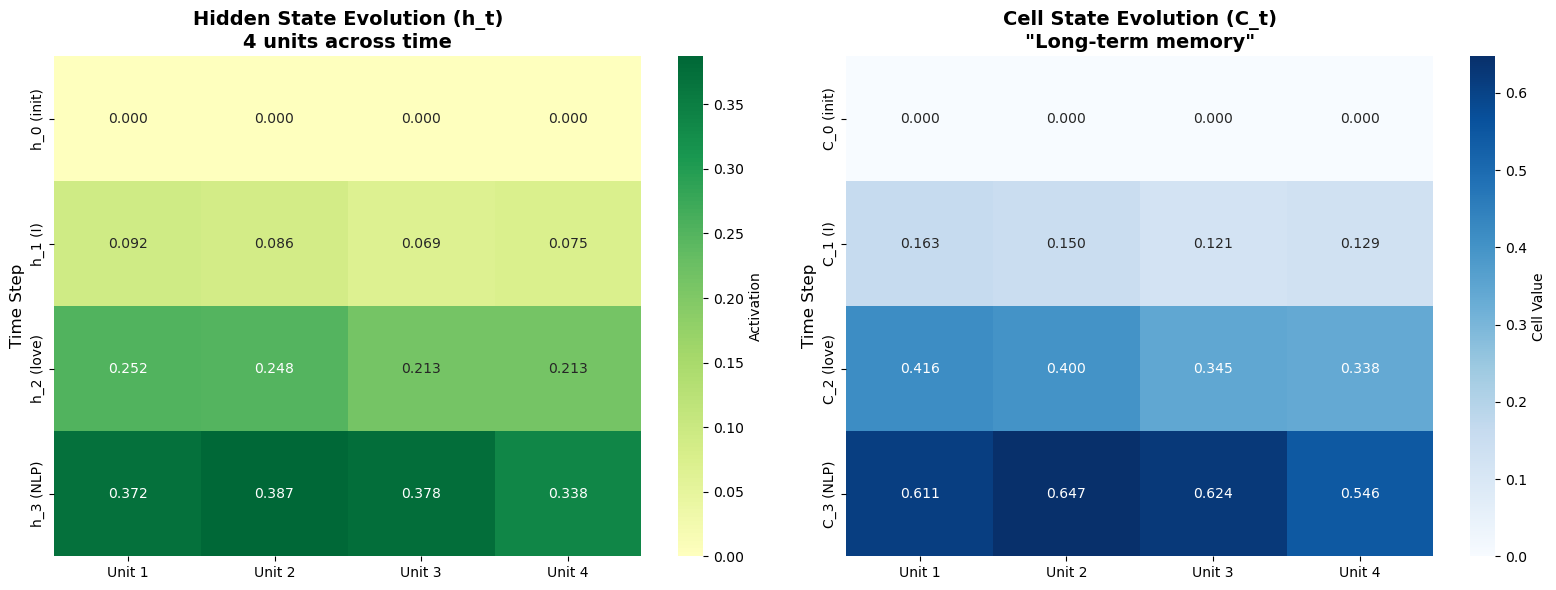

Visualization saved as 'lstm_state_evolution.png'


In [27]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Hidden states
ax1 = axes[0]
sns.heatmap(hidden_states, annot=True, fmt='.3f', cmap='RdYlGn',
            center=0, cbar_kws={'label': 'Activation'},
            xticklabels=['Unit 1', 'Unit 2', 'Unit 3', 'Unit 4'],
            yticklabels=['h_0 (init)', 'h_1 (I)', 'h_2 (love)', 'h_3 (NLP)'],
            ax=ax1)
ax1.set_title('Hidden State Evolution (h_t)\n4 units across time', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('Time Step', fontsize=12)

# Cell states
ax2 = axes[1]
sns.heatmap(cell_states, annot=True, fmt='.3f', cmap='Blues',
            cbar_kws={'label': 'Cell Value'},
            xticklabels=['Unit 1', 'Unit 2', 'Unit 3', 'Unit 4'],
            yticklabels=['C_0 (init)', 'C_1 (I)', 'C_2 (love)', 'C_3 (NLP)'],
            ax=ax2)
ax2.set_title('Cell State Evolution (C_t)\n"Long-term memory"', 
              fontsize=14, fontweight='bold')
ax2.set_ylabel('Time Step', fontsize=12)

plt.tight_layout()
plt.savefig('lstm_state_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'lstm_state_evolution.png'")

## Visualization 2: Gate Activations

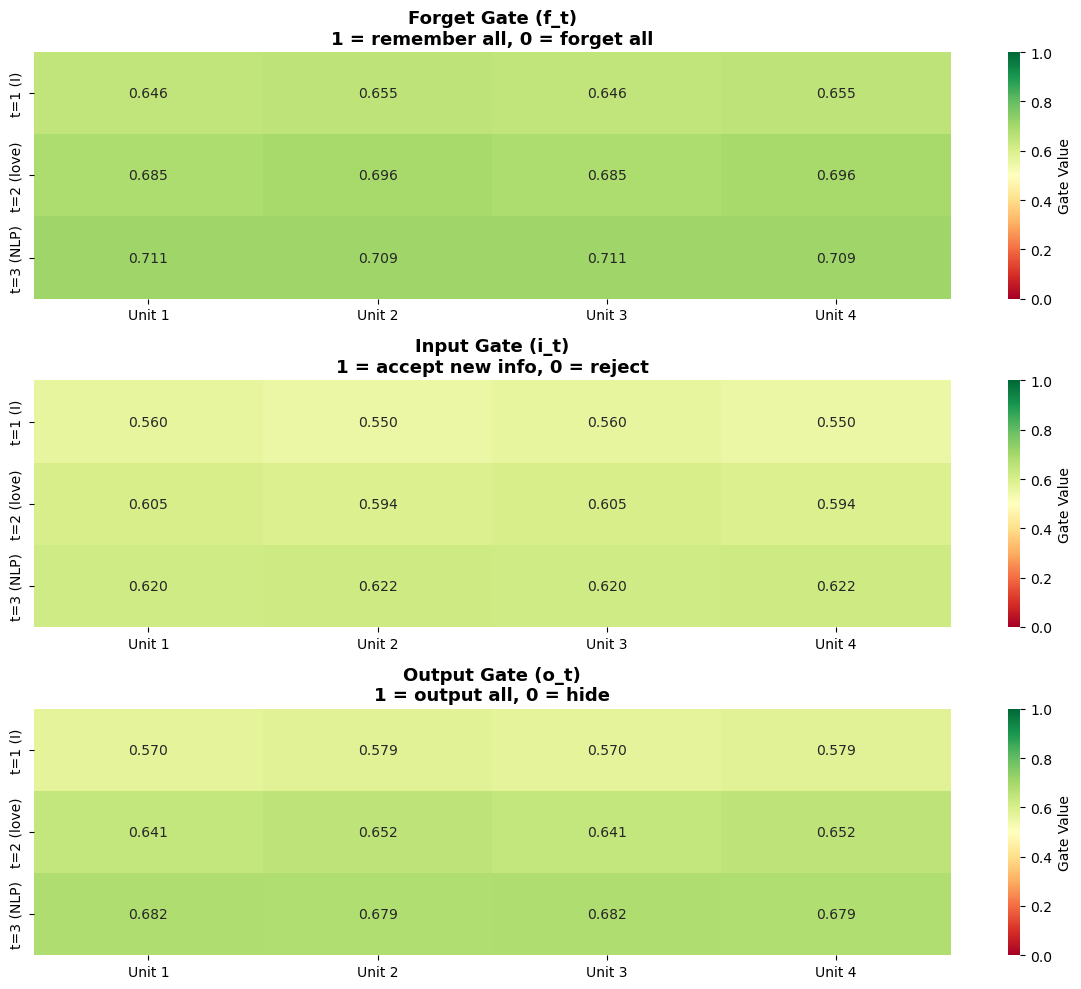

Visualization saved as 'lstm_gate_activations.png'


In [28]:
# Collect gate values
forget_gates = np.array([f_1, f_2, f_3])
input_gates = np.array([i_1, i_2, i_3])
output_gates = np.array([o_1, o_2, o_3])

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

time_labels = ['t=1 (I)', 't=2 (love)', 't=3 (NLP)']
unit_labels = ['Unit 1', 'Unit 2', 'Unit 3', 'Unit 4']

# Forget gate
sns.heatmap(forget_gates, annot=True, fmt='.3f', cmap='RdYlGn',
            vmin=0, vmax=1, cbar_kws={'label': 'Gate Value'},
            xticklabels=unit_labels, yticklabels=time_labels,
            ax=axes[0])
axes[0].set_title('Forget Gate (f_t)\n1 = remember all, 0 = forget all', 
                  fontsize=13, fontweight='bold')

# Input gate
sns.heatmap(input_gates, annot=True, fmt='.3f', cmap='RdYlGn',
            vmin=0, vmax=1, cbar_kws={'label': 'Gate Value'},
            xticklabels=unit_labels, yticklabels=time_labels,
            ax=axes[1])
axes[1].set_title('Input Gate (i_t)\n1 = accept new info, 0 = reject', 
                  fontsize=13, fontweight='bold')

# Output gate
sns.heatmap(output_gates, annot=True, fmt='.3f', cmap='RdYlGn',
            vmin=0, vmax=1, cbar_kws={'label': 'Gate Value'},
            xticklabels=unit_labels, yticklabels=time_labels,
            ax=axes[2])
axes[2].set_title('Output Gate (o_t)\n1 = output all, 0 = hide', 
                  fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('lstm_gate_activations.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'lstm_gate_activations.png'")

## Visualization 3: LSTM Architecture Diagram

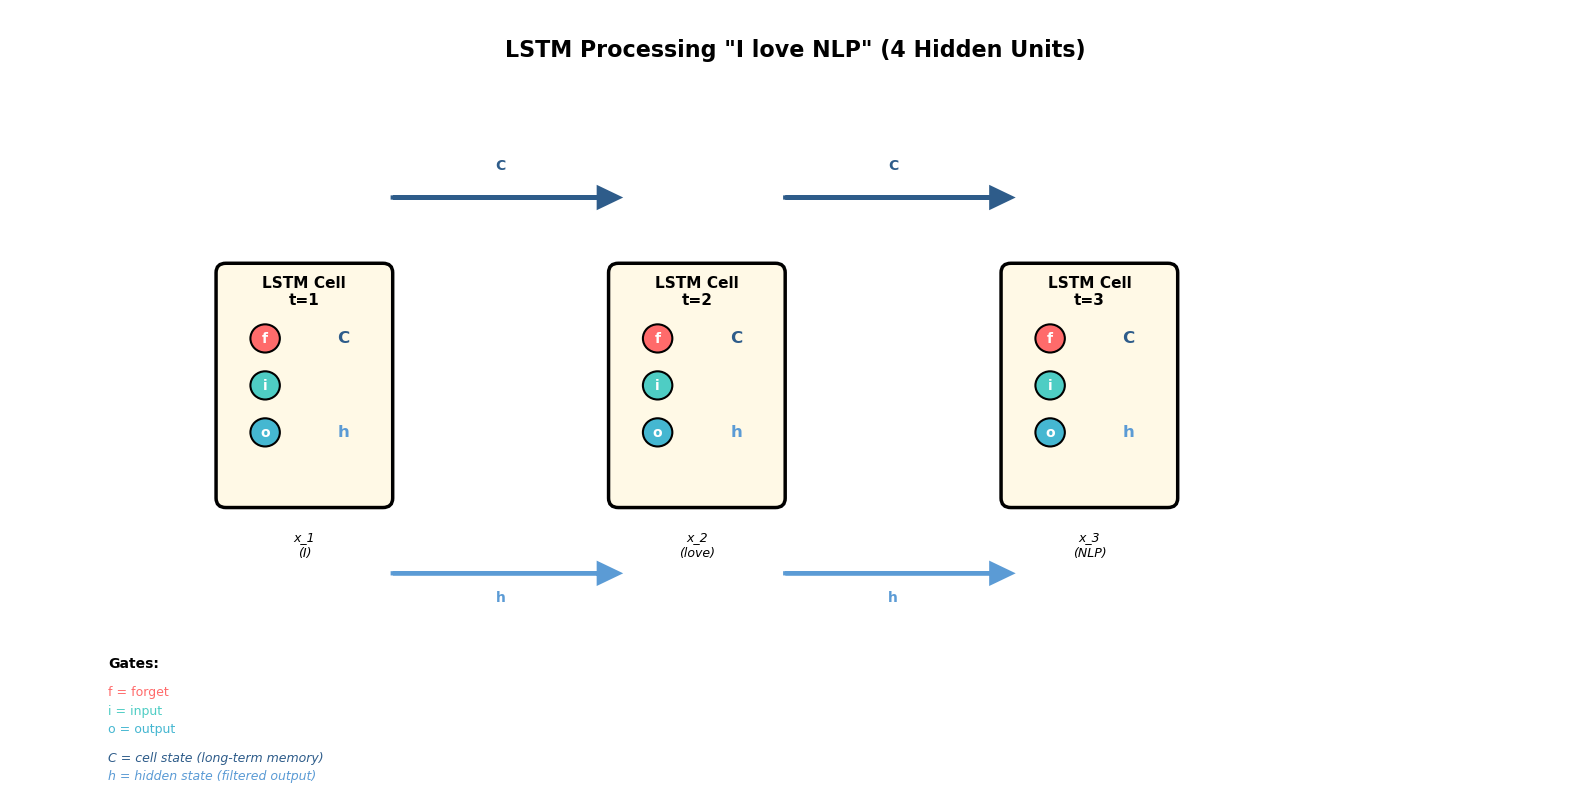

Visualization saved as 'lstm_architecture_diagram.png'


In [29]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_xlim(0, 16)
ax.set_ylim(0, 8)
ax.axis('off')

# Helper to draw LSTM cell
def draw_lstm_cell(ax, x, y, word, step):
    # Main box
    box = FancyBboxPatch((x-0.8, y-1.2), 1.6, 2.4, 
                          boxstyle="round,pad=0.1",
                          edgecolor='black', facecolor='#FFF9E6', 
                          linewidth=2.5)
    ax.add_patch(box)
    
    # Title
    ax.text(x, y + 1.0, f'LSTM Cell\nt={step}', 
            ha='center', va='center', fontsize=11, fontweight='bold')
    
    # Input
    ax.text(x, y - 1.7, f'x_{step}\n({word})', 
            ha='center', va='center', fontsize=9, style='italic')
    
    # Gates (simplified representation)
    gate_y = [y + 0.5, y, y - 0.5]
    gate_labels = ['f', 'i', 'o']
    gate_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for gy, label, color in zip(gate_y, gate_labels, gate_colors):
        circle = plt.Circle((x - 0.4, gy), 0.15, 
                           color=color, ec='black', linewidth=1.5)
        ax.add_patch(circle)
        ax.text(x - 0.4, gy, label, ha='center', va='center', 
               fontsize=10, fontweight='bold', color='white')
    
    # Cell state representation
    ax.text(x + 0.4, y + 0.5, 'C', ha='center', va='center',
           fontsize=12, fontweight='bold', color='#2E5C8A')
    
    # Hidden state representation  
    ax.text(x + 0.4, y - 0.5, 'h', ha='center', va='center',
           fontsize=12, fontweight='bold', color='#5B9BD5')

# Draw 3 LSTM cells
x_positions = [3, 7, 11]
words = ['I', 'love', 'NLP']

for i, (x, word) in enumerate(zip(x_positions, words)):
    draw_lstm_cell(ax, x, 4, word, i+1)
    
    # Cell state flow (top arrow)
    if i < len(x_positions) - 1:
        ax.arrow(x + 0.9, 6, x_positions[i+1] - x - 1.9, 0,
                head_width=0.2, head_length=0.2, 
                fc='#2E5C8A', ec='#2E5C8A', linewidth=3)
        ax.text((x + x_positions[i+1])/2, 6.3, 'C', 
               ha='center', fontsize=10, color='#2E5C8A', fontweight='bold')
    
    # Hidden state flow (bottom arrow)
    if i < len(x_positions) - 1:
        ax.arrow(x + 0.9, 2, x_positions[i+1] - x - 1.9, 0,
                head_width=0.2, head_length=0.2,
                fc='#5B9BD5', ec='#5B9BD5', linewidth=3)
        ax.text((x + x_positions[i+1])/2, 1.7, 'h',
               ha='center', fontsize=10, color='#5B9BD5', fontweight='bold')

# Title
ax.text(8, 7.5, 'LSTM Processing "I love NLP" (4 Hidden Units)', 
        ha='center', fontsize=16, fontweight='bold')

# Legend
legend_x = 1
legend_y = 1
ax.text(legend_x, legend_y, 'Gates:', fontsize=10, fontweight='bold')
ax.text(legend_x, legend_y - 0.3, 'f = forget', fontsize=9, color='#FF6B6B')
ax.text(legend_x, legend_y - 0.5, 'i = input', fontsize=9, color='#4ECDC4')
ax.text(legend_x, legend_y - 0.7, 'o = output', fontsize=9, color='#45B7D1')
ax.text(legend_x, legend_y - 1.0, 'C = cell state (long-term memory)', 
        fontsize=9, color='#2E5C8A', style='italic')
ax.text(legend_x, legend_y - 1.2, 'h = hidden state (filtered output)', 
        fontsize=9, color='#5B9BD5', style='italic')

plt.tight_layout()
plt.savefig('lstm_architecture_diagram.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'lstm_architecture_diagram.png'")

## Comparison: RNN vs LSTM

In [30]:
print("\n" + "="*70)
print("RNN vs LSTM COMPARISON")
print("="*70)

comparison = [
    ("States", "1 state (h_t)", "2 states (h_t, C_t)"),
    ("Gates", "None", "3 gates (forget, input, output)"),
    ("Memory", "Short-term only", "Long-term (C_t) + Short-term (h_t)"),
    ("Parameters", "~32 (for 4 hidden units)", "~128 (4× more)"),
    ("Vanishing gradient", "Problem", "Mitigated by gates"),
    ("Long sequences", "Struggles", "Handles better"),
    ("Complexity", "Simple", "More complex"),
    ("Training speed", "Faster", "Slower (more params)"),
]

print(f"{'Aspect':<20} {'RNN':<30} {'LSTM':<30}")
print("-"*70)
for aspect, rnn, lstm in comparison:
    print(f"{aspect:<20} {rnn:<30} {lstm:<30}")
print("="*70)

print("\nKey Insight:")
print("LSTM's gates allow it to:")
print("  1. Selectively remember/forget information (forget gate)")
print("  2. Decide what new information to store (input gate)")
print("  3. Control what to output (output gate)")
print("  4. Maintain long-term dependencies through cell state")
print("\nThis makes LSTM much better for long sequences!")


RNN vs LSTM COMPARISON
Aspect               RNN                            LSTM                          
----------------------------------------------------------------------
States               1 state (h_t)                  2 states (h_t, C_t)           
Gates                None                           3 gates (forget, input, output)
Memory               Short-term only                Long-term (C_t) + Short-term (h_t)
Parameters           ~32 (for 4 hidden units)       ~128 (4× more)                
Vanishing gradient   Problem                        Mitigated by gates            
Long sequences       Struggles                      Handles better                
Complexity           Simple                         More complex                  
Training speed       Faster                         Slower (more params)          

Key Insight:
LSTM's gates allow it to:
  1. Selectively remember/forget information (forget gate)
  2. Decide what new information to store (input gate)

## Key Takeaways

### What are the Hidden and Cell States?

**Both are 4-dimensional vectors** (one value per hidden unit)

```python
h_3 = [0.31, 0.42, 0.38, 0.45]  # Hidden state - filtered output
C_3 = [0.52, 0.68, 0.61, 0.73]  # Cell state - long-term memory
```

### How Information Flows

1. **t=1**: Process "I" → produces h_1 and C_1
2. **t=2**: Process "love" + (h_1, C_1) → produces h_2 and C_2
   - Forget gate decides what to keep from C_1
   - Input gate decides how much new info to add
3. **t=3**: Process "NLP" + (h_2, C_2) → produces h_3 and C_3
   - Cell state C_3 carries long-term memory of entire sentence
   - Hidden state h_3 is filtered version for output

### Final States

- **C_3 (cell state)**: Long-term memory encoding "I love NLP"
- **h_3 (hidden state)**: Filtered output for prediction/next layer

### Why LSTM > RNN?

- **Gates prevent vanishing gradients**: Information can flow unchanged through cell state
- **Selective memory**: Can choose what to remember/forget
- **Better for long sequences**: Maintains information over many time steps

### Trade-off

- **RNN**: Simpler, faster, fewer parameters
- **LSTM**: More powerful, handles long dependencies, but slower and more parameters